<a href="https://colab.research.google.com/github/ubclaunchpad/tl-dr/blob/optimization/summary_be/ml_notebook/dynamic_chunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Chunking
This notebook implements dynamic chunking of text into semantically distinct paragraphs.

*   [SBERT](https://www.sbert.net/) is used to extract semantic feature vectors in sentences
*   Vectors can be compared to find sentences of similar meaning

Dynamic chunking solves the following problems:


*   Summarization of long texts
*   Preservation of detail in the overall summary

**TODO**
*   This notebook is not complete, missing examples and explanations
*   Compare time for each method


In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from tqdm import tnrange
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
MODEL = 'all-MiniLM-L6-v2'
model = SentenceTransformer(MODEL)

In [ ]:
TEXT = """Elon Musk sold $3.95 billion worth of Tesla stock since completing his purchase of Twitter late last month. 
          Musk’s Tesla stock sales, totaling 19.5 million shares, have been widely anticipated ever since the Tesla CEO
          reached a deal to buy Twitter for $44 billion. Musk had sold blocks of Tesla shares worth a total of $15.4 billion
          earlier this year since his deal to buy Twitter was announced. Twitter confirmed Musk bought the social media company
          October 27, but he waited until November 4 to start selling additional Tesla shares. He also sold blocks of Tesla 
          stock on Monday and Tuesday this week, according to filings to the Securities and Exchange Commission late Tuesday night. 
          It’s not clear if the money Musk raised went toward the Twitter purchase, or to support losses at Twitter since he 
          took over. Musk disclosed last week that Twitter has seen a “massive drop in revenue,” as a growing number of advertisers 
          pause spending on the platform in the wake of his takeover of the company. He blamed “activist groups” pressuring 
          advertisers for the loss of ad dollars. He has announced plans to charge users $8 a month to have verified accounts, 
          and also announced deep staff cuts. This is not the best time to be selling Tesla shares, which have lost 46% of their 
          value so far this year on disappointing sales caused by supply chain problems. Musk received an average price of $202.52 
          for the Tesla shares he sold since the Twitter deal closed, which is down 10% just since he closed on his deal to buy 
          Twitter. Shares of Tesla fell 0.7% in after-hours trading Tuesday. The company is facing growing competition in the 
          electric vehicle market from established automakers such as Volkswagen, Ford and General Motors. And some investors 
          have expressed concerns that Musk will be too distracted by his purchase of Twitter to give enough attention to 
          addressing Tesla’s problems."""

In [ ]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")

## Cosine-similarity matrix
Sentence embeddings are compared using cosine-similarity to find similar sentences.

The closer the value is to 1, the smaller the angle between the vectors and the more similar the sentences are to each other.

In [ ]:
def embed_sentences(text):
    sent_embeddings = sent_tokenize(text)
    for i in range (len(sent_embeddings)):
        sent_embeddings[i] = model.encode(sent_embeddings[i])
    return sent_embeddings

def create_similarity_matrix(sent_embeddings):
    similarity_matrix = cosine_similarity(sent_embeddings)
    return similarity_matrix

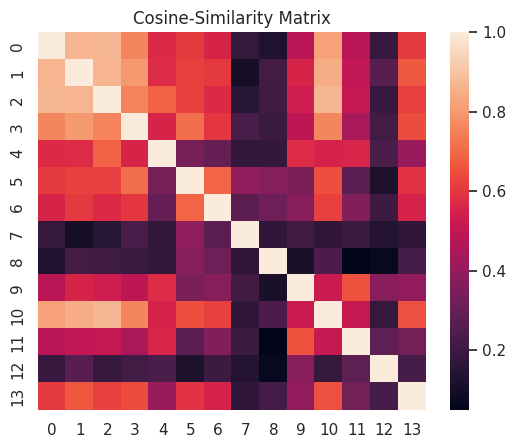

In [ ]:
similarity_matrix = create_similarity_matrix(embed_sentences(TEXT))
sns.set(rc={'figure.figsize':(6.25, 5)})
sns.heatmap(similarity_matrix).set_title('Cosine-Similarity Matrix')
plt.show()

## Dynamic Chunking While Preserving Order

This approach exploits the existing structure of a news article, which groups topics together into sequential chunks.

We are concerned with finding **where** the "topic" changes, and inserting a breakpoint. Once these chunks are discovered, we can use parallel processing to generate summaries of each chunk and concatenate them together.

In [ ]:
def rev_sigmoid(x):
    return (1 / (1 + math.exp(0.5*x)))

def find_splitting_points(similarity_matrix):
    size = 14
    x = np.linspace(-10, 10, size)
    y = np.vectorize(rev_sigmoid)
    activation_weights = np.pad(y(x), (0, similarity_matrix.shape[0] - size))
    diagonals = [similarity_matrix.diagonal(each) for each in range(0, similarity_matrix.shape[0])]
    diagonals = [np.pad(each, (0, similarity_matrix.shape[0]-len(each))) for each in diagonals]
    diagonals = np.stack(diagonals)
    diagonals = diagonals * activation_weights.reshape(-1, 1)
    weighted_sum = np.sum(diagonals, axis = 0)
    return weighted_sum

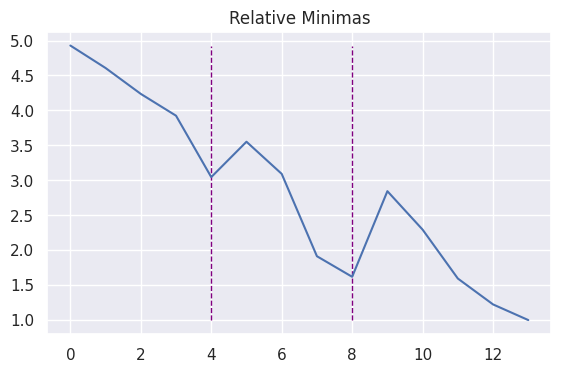

In [ ]:
activated_similarities = find_splitting_points(similarity_matrix)
fig, ax = plt.subplots()
minmimas = argrelextrema(activated_similarities, np.less, order=2)
sns.set(rc={'figure.figsize':(6.5, 5)})
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative Minimas')
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')
plt.show()

## Clustering by Topic

We can also group sentences together by semantic meaning.

This approach allows us to keep track of "topics" that are most prevalent in the text, which is an indicator of relevance. Advantages include being able to adjust the length of a text summary while having control over which topics appear in the summary. For example, if the client requests a short summary, we could choose to summarize and concatenate only sentences that embody the most prevalent topics.


In [ ]:
sentences = sent_tokenize(TEXT)
sentences = [sentence.strip() for sentence in sentences]
data = pd.DataFrame(sentences)

In [ ]:
def get_sentence_embeddings(sentence):
    embedding = model.encode([sentence])
    return embedding[0]

In [ ]:
from nltk.cluster import KMeansClusterer
def cluster(NUM_CLUSTERS = 3):
    data.columns=['sentence']
    data['embeddings']=data['sentence'].apply(get_sentence_embeddings)

    iterations=25
    X = np.array(data['embeddings'].tolist())
    kclusterer = KMeansClusterer(
            NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
            repeats=iterations,avoid_empty_clusters=True)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    data['cluster']=assigned_clusters
    return data

In [ ]:
cluster()

,sentence,embeddings,cluster
0,Elon Musk sold $3.95 billion worth of Tesla st...,"[0.015738262, 0.049773764, 0.039228562, -0.002...",1
1,"Musk’s Tesla stock sales, totaling 19.5 millio...","[0.0046068756, 0.010958798, 0.06972741, 0.0108...",1
2,Musk had sold blocks of Tesla shares worth a t...,"[-0.014365158, 0.05811444, 0.053490557, 0.0085...",1
3,Twitter confirmed Musk bought the social media...,"[0.0058419057, -0.014379907, 0.07404005, 0.016...",1
4,He also sold blocks of Tesla \n stock...,"[-0.054390516, 0.033562854, -0.004229972, 0.01...",0
5,It’s not clear if the money Musk raised went t...,"[0.007103605, 0.03970247, 0.091158584, -0.0287...",1
6,Musk disclosed last week that Twitter has seen...,"[0.017648496, 0.047859456, 0.077083685, -0.027...",2
7,He blamed “activist groups” pressuring \n ...,"[0.0009142382, 0.03492736, -0.017508835, 0.071...",2
8,He has announced plans to charge users $8 a mo...,"[-0.04066035, -0.04515377, 0.045038592, -0.019...",2
9,This is not the best time to be selling Tesla ...,"[-0.02830206, 0.01951779, 0.061164685, 0.02635...",0
